# Data Preprocessing

In [ ]:
import pandas as pd
import re

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(palette='deep', color_codes=True, font_scale=1.3)

from string import punctuation

df = pd.read_csv("https://raw.githubusercontent.com/tassiasP/text_analytics_airline/main/Tweets.csv")
df.sample(10).head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
4057,567847753277120512,positive,1.000,NaN,NaN,United,NaN,dudleywright,NaN,0,@united thanks for not getting my BusinessFirs...,NaN,2015-02-17 16:47:09 -0800,"Johnstown, Ohio",Quito
9493,569907782108839938,negative,0.967,Can't Tell,0.8042,US Airways,negative,mydulcebella,Can't Tell,1,@USAirways / @AmericanAir don't forget without...,NaN,2015-02-23 09:12:58 -0800,Pennsylvania,Eastern Time (US & Canada)
6480,567823996852428801,negative,1.000,Customer Service Issue,0.3653,Southwest,NaN,pjta22one,NaN,0,@SouthwestAir stop ur bs promos of ✈️anywhere ...,NaN,2015-02-17 15:12:45 -0800,NaN,NaN
841,570055700790931456,negative,1.000,Customer Service Issue,0.6667,United,NaN,JeffPKirkland,NaN,0,@united computers are down but you stopped giv...,NaN,2015-02-23 19:00:44 -0800,Oregon,Pacific Time (US & Canada)
11265,568258075431477248,negative,1.000,Customer Service Issue,1.0000,US Airways,NaN,tannapistolis,NaN,0,@USAirways worst customer service. Still not p...,NaN,2015-02-18 19:57:37 -0800,NaN,Eastern Time (US & Canada)


After downloading the dataset, we clean the tweets from numbers, mentions, punctuation etc.

In [ ]:
def clean_text(text):
    #match http, s is optional, :// one slash is optional and everything that is not a whitespace
    hyperlinks = re.compile(r'https?://?[\S]*')
    text = re.sub(hyperlinks,'',text)
    
    #match RT and remove, because of retweets
    retweets = re.compile(r'RT')
    text = re.sub(retweets,'',text)

    #finding @ and match everything that is in [a-zA-Z0-9_]. this will include mentions without a separating space
    mentions = re.compile(r'@\w*')
    text = re.sub(mentions,'',text)
    
    #remove new line characters
    newline = re.compile(r'\n')
    text = re.sub(newline,'',text)

    #remove apostrophes    
    apostroph = re.compile("'")
    text = re.sub(apostroph,' ',text)
    
    #remove single characters
    single_chars = re.compile(r'\s+[a-zA-Z]\s+')
    text = re.sub(single_chars, ' ', text)
    
    # punctuation = re.compile(r'[\W]')
    text = re.sub(f"[{punctuation}]",' ',text)
    
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    text = text.lower()
    
    return text

Then we tokenize the text, find the stems for each word and recostruct it, since TfIdf uses a text as a whole.

In [ ]:
df['cleaned_text'] = df.text.apply(clean_text)
df['tokenized_text'] = df.cleaned_text.apply(word_tokenize)

stemmer = PorterStemmer()
df['stemmed_text'] = df.tokenized_text.apply(lambda sent: [stemmer.stem(word) for word in sent])

df['reconstructed_text'] = df.stemmed_text.apply(lambda sent: ' '.join(word for word in sent))

# lemmatizer = WordNetLemmatizer()
# df['lemmatized_text'] = df.tokenized_text.apply(lambda sent: [lemmatizer.lemmatize(word) for word in sent])

In [ ]:
df[['text', 'cleaned_text','stemmed_text', 'reconstructed_text']].head()

,text,cleaned_text,stemmed_text,reconstructed_text
0,@VirginAmerica What @dhepburn said.,what said,"[what, said]",what said
1,@VirginAmerica plus you've added commercials t...,plus you ve added commercials to the experien...,"[plu, you, ve, ad, commerci, to, the, experi, ...",plu you ve ad commerci to the experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,didn today must mean need to take another trip,"[didn, today, must, mean, need, to, take, anot...",didn today must mean need to take anoth trip
3,@VirginAmerica it's really aggressive to blast...,it really aggressive to blast obnoxious enter...,"[it, realli, aggress, to, blast, obnoxi, enter...",it realli aggress to blast obnoxi entertain in...
4,@VirginAmerica and it's a really big bad thing...,and it a really big bad thing about it,"[and, it, a, realli, big, bad, thing, about, it]",and it a realli big bad thing about it


Create a mapping for the labels

In [ ]:
label_dict = {'positive': 2, 'neutral': 1, 'negative': 0}
label_dict_one_hot = {'positive': np.array([0,0,1]), 'neutral': np.array([0,1,0]), 'negative': np.array([1,0,0])}
df['airline_sentiment_label'] = df['airline_sentiment'].map(label_dict)
df['airline_sentiment_label_one_hot'] = df['airline_sentiment'].map(label_dict_one_hot)

Check the distribution among the classes.

In [ ]:
df['airline_sentiment_label'].value_counts() / len(df)

0    0.626913
1    0.211680
2    0.161407
Name: airline_sentiment_label, dtype: float64

Then split the data in train and test in a stratified manner, startified by the label and the airline.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, shuffle=True, stratify=df[['airline_sentiment_label', 'airline']],
                               test_size=0.15, random_state=9)

train, validation = train_test_split(train, shuffle=True, stratify=train[['airline_sentiment_label', 'airline']],
                               test_size=0.2, random_state=9)

In [ ]:
print(f"Training Set:{len(train) / len(df) * 100 : .2f} %, \
 Validation Set:{len(validation) / len(df) * 100 : .2f} % \
 Test Set:{len(test) / len(df) * 100 : .2f} %")

Training Set: 68.00 %,  Validation Set: 17.00 %  Test Set: 15.00 %


# TFIDF with Logistic Regression

This is our baseline model. In order to take advantage of the GridsearchCV as well as keep a clean split between train, validation and split we used the PredefinedSplit class in order to keep the train and validation set static.

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

X_train = train.reconstructed_text
X_val = validation.reconstructed_text
X_test = test.reconstructed_text

y_train = train.airline_sentiment_label
y_val = validation.airline_sentiment_label
y_test = test.airline_sentiment_label

train_indices = [-1] * len(train)
val_indices = [0] * len(validation)
ps = PredefinedSplit(test_fold=np.concatenate((train_indices,val_indices)))
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

Then we train the Tfidf vectorizer as well as the LogisticRegression model using a pipeline in combination with GridSearchCV.

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = stopwords.words('english'))),
    ('clf', LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=200, random_state=1234))
    ])

grid_params = {
  'clf__C': np.linspace(0.05, 50, 25),
  'vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
  'vectorizer__max_features': [1500, 2500, 5000],
}

lr = GridSearchCV(pipe, grid_params, scoring='f1_macro', cv=ps, n_jobs=-1, verbose=4)
lr.fit(X=X_train_val,  y = y_train_val)

print("Best Score: ", lr.best_score_)
print("Best Params: ", lr.best_params_)

#refit only on train after best param
X_train_transformed = lr.best_estimator_.named_steps['vectorizer'].fit_transform(X_train)
lr.best_estimator_.named_steps['clf'].fit(X_train_transformed, y_train)

Fitting 1 folds for each of 225 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  2.9min finished


Best Score:  0.7216601211103882
Best Params:  {'clf__C': 2.13125, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 3)}


LogisticRegression(C=2.13125, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1234, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

Next we plot the results

In [ ]:
from sklearn.metrics import classification_report

def evaluation(y_true, y_pred, set_type):
    metrics = ['precision', 'recall', 'f1-score']
    cr = classification_report(y_true, y_pred, output_dict=True)
    res = []
    for metric in metrics:
        res.append((cr['0'][metric], cr['1'][metric], cr['2'][metric], set_type, metric))
    return res

def clf_plot_evaluation(res, title):
    fig, axs = plt.subplots(1, 3, figsize=(14,3.5), sharey=True)
    fig.subplots_adjust(top=0.8, wspace=0.1)

    sns.barplot(x = 'class', y = 'score', hue='set', data = res[res.metric=='precision'], ax = axs[0])
    axs[0].title.set_text('Precision')
    axs[0].set_ylabel('metric score')

    sns.barplot(x = 'class', y = 'score', hue='set', data = res[res.metric=='recall'], ax = axs[1])
    axs[1].title.set_text('Recall')
    axs[1].set_ylabel('')
    
    sns.barplot(x = 'class', y = 'score', hue='set', data = res[res.metric=='f1-score'], ax = axs[2])
    axs[2].title.set_text('f1-score')
    axs[2].set_ylabel('')
    
    handles, labels = axs[0].get_legend_handles_labels()
    axs[0].legend(handles[:0], labels[:0]) 
    axs[1].legend(handles[:0], labels[:0])
    axs[2].legend(handles[:0], labels[:0]) 
    fig.legend(handles, labels, loc='upper right', fontsize='small')

    plt.ylim(0,1)
    plt.suptitle(title)
    plt.show()

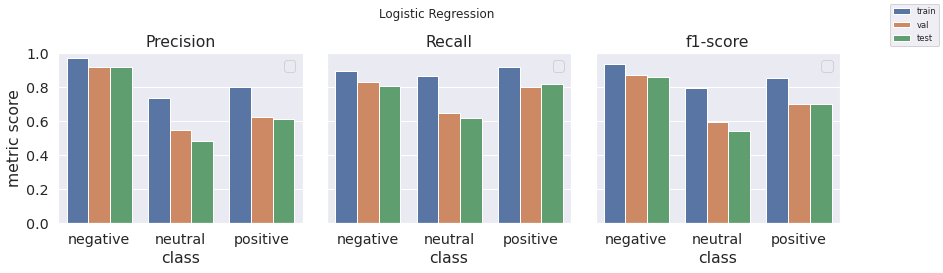

In [ ]:
res_lr = pd.DataFrame(
    evaluation(lr.predict(X_train), y_train, 'train') \
    + evaluation(lr.predict(X_val), y_val, 'val') \
    + evaluation(lr.predict(X_test), y_test, 'test') \
   ,columns = ['negative', 'neutral', 'positive', 'set', 'metric']
)

res_lr = pd.melt(res_lr, id_vars = ['set','metric'], value_vars=['negative','neutral','positive'], var_name='class', value_name='score')
clf_plot_evaluation(res_lr, 'Logistic Regression')

# Load the Embeddings

Since we have trained a baseline model, we will continue with fitting 2 Multilayer Perceptrons. The input of both models is based on the pretrained GloVe embeddings.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-26 16:00:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-26 16:00:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-26 16:00:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import csv
pretrained_embeddings = pd.read_table("glove.6B.300d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
pretrained_embeddings.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,-0.26091,0.032434,0.056621,-0.043296,-0.021672,0.224760,-0.075129,-0.067018,-0.142470,0.038825,-0.189510,0.29977,0.393050,0.178870,-0.173430,-0.211780,0.236170,-0.063681,-0.423180,-0.116610,0.093754,0.172960,-0.33073,0.491120,-0.68995,-0.092462,0.247420,-0.179910,0.097908,0.083118,...,-0.287970,-0.058996,-0.032436,-0.004701,-0.170520,-0.034741,-0.114890,0.075093,0.099526,0.048183,-0.073775,-0.418170,0.004127,0.44414,-0.16062,0.142940,-2.2628,-0.027347,0.81311,0.774170,-0.256390,-0.115760,-0.119820,-0.21363,0.028429,0.27261,0.031026,0.096782,0.006777,0.140820,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,0.58509,0.036501,-0.198460,0.196130,0.409290,0.157020,-0.153050,0.050447,0.300450,-0.112950,-0.017043,0.18593,0.199820,0.200530,-0.631410,-0.126220,0.295100,-0.262820,-0.158310,0.001238,0.011784,0.587580,-0.15914,0.277310,-0.82343,-0.211340,0.013414,0.196370,-0.414700,0.001028,...,-0.063187,-0.245530,-0.059751,0.068787,-0.116270,-0.008340,0.005204,-0.201590,-0.023663,0.175620,-0.314750,-0.111620,-0.124920,0.10949,-0.26913,0.348930,-1.6997,-0.244700,0.30292,0.056720,-0.317370,0.083612,0.095949,-0.17590,0.102350,0.36808,-0.343800,0.206070,0.191350,0.109920,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,0.22393,0.124090,-0.086708,0.330100,0.343750,-0.000876,-0.296580,0.244170,-0.115920,-0.035742,-0.010830,0.20776,0.292850,-0.073491,-0.185980,-0.200900,-0.095366,0.006373,-0.136200,0.092028,-0.039957,0.190270,-0.10456,0.002767,-0.71742,-0.129150,-0.001345,0.270020,-0.053023,0.221480,...,-0.136670,-0.439620,0.237040,0.031296,0.074701,-0.223870,0.007816,-0.190160,0.044444,0.201910,-0.208140,-0.283820,0.104270,-0.21098,0.18865,0.316590,-2.0753,-0.071045,0.52419,0.056023,-0.252950,-0.062168,-0.109890,-0.35755,-0.079244,0.37472,-0.283530,0.163370,0.111650,-0.098002,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,-0.22464,0.042690,-0.401800,0.210060,0.014288,0.416280,0.017165,0.071732,0.006925,0.181070,-0.154120,0.14933,-0.030493,0.299180,0.029479,-0.036147,-0.061125,0.083918,-0.123980,-0.100770,-0.005414,0.337100,-0.25612,0.443880,-0.68922,0.180200,0.348980,-0.052284,-0.262260,-0.471090,...,0.467280,0.482140,0.105480,0.065805,0.067221,0.133210,-0.278560,0.015532,0.300260,0.387480,-0.144010,-0.161310,0.176780,0.16448,-0.32440,0.007937,-2.2836,0.096945,0.66131,0.168570,-0.028877,-0.107910,-0.027445,-0.25695,0.046686,0.23087,-0.076458,0.271270,0.251850,0.054947,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,-0.11258,-0.129550,0.272540,0.007289,0.260380,0.120960,-0.231930,0.032260,-0.294720,-0.675940,-0.338440,-0.23297,0.110200,0.188160,-0.451840,-0.338330,0.112740,0.494900,-0.042132,0.079961,-0.013146,0.062284,0.20223,0.038279,-1.11540,-0.121400,0.089846,0.297020,-0.055794,-0.460210,...,0.327080,-0.520490,0.037555,0.023667,-0.068237,-0.229160,0.017755,-0.183940,0.551070,-0.239650,0.391870,-0.017785,0.431130,0.27181,-0.16043,-0.347000,-2.4194,-0.028952,0.95085,0.058040,-0.236230,0.189140,0.311920,0.23064,-0.303090,-0.18603,

A class to use as callback that import precision, recall and f1 socres in the history log.

In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        
        _val_f1 = f1_score(val_targ, val_predict,average="macro")
        _val_recall = recall_score(val_targ, val_predict,average="macro")
        _val_precision = precision_score(val_targ, val_predict,average="macro")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In order to tune the hyperparameters of the model, we used the keras hypertuner. We need to pip install it since colab does not include it by default.

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 5.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=cb0f6f0c2ad51e007958433c9ae46e5e0363aa633e99ae487345d207b17b3b78
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=41966e6b7a0ab3209a2575e5c8af54eb36c89e5b4fb077b97de8f48deb15f1f2
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import AveragePooling1D
from keras.layers import Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Trainable Embeddings

In this MLP model, we include an embedding layer with the Glove embeddings as initial weights. Additionally we set them to trainable, in order to adjust them to our task.

The next function tries to find common words between the glove embeddings and each sentence. Additionally, stopwords are removed from each sentence. This process has been implemented using sets as data structures, in order to utilize their operations such as intersection and subtraction.

In [ ]:
pretrained_embeddings_words = set(pretrained_embeddings.index)
stop_words_set = set(stopwords.words('english'))

def keep_matching_words(tokenized_text):
    matching_words = []
    tok = set(tokenized_text)
    matched = tok.intersection(pretrained_embeddings_words)
    matched = matched - stop_words_set
    for word in tokenized_text:
        if word in matched:
            matching_words.append(word)
    return ' '.join(matching_words)

train['matching_words'] = train.tokenized_text.apply(keep_matching_words)
validation['matching_words'] = validation.tokenized_text.apply(keep_matching_words)
test['matching_words'] = test.tokenized_text.apply(keep_matching_words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In order to decide for the optmimal max len for the train data, we plot their lengths. The plot includes the distribution of all sets, in order to make sure that we observe the same lengths during training validation and testing.

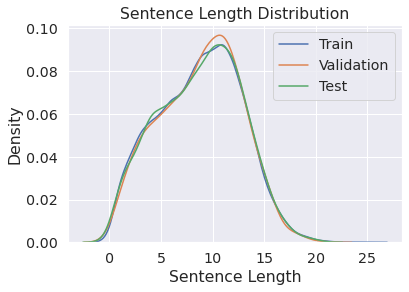

In [ ]:
sns.kdeplot(train.matching_words.apply(lambda x: len(x.split())), label = 'Train')
sns.kdeplot(validation.matching_words.apply(lambda x: len(x.split())), label = 'Validation')
sns.kdeplot(test.matching_words.apply(lambda x: len(x.split())), label = 'Test')
plt.xlabel('Sentence Length')
plt.title('Sentence Length Distribution')
plt.legend()
plt.show()

Next we utilize the keras Tokenizer and pad our sequences.

In [ ]:
t = Tokenizer()
t.fit_on_texts(train.matching_words)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(train.matching_words)
max_len = 15
train_padded_docs_mlp = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
y_train = np.vstack(train.airline_sentiment_label_one_hot)

In [ ]:
val_encoded_docs = t.texts_to_sequences(validation.matching_words)
val_padded_docs_mlp = pad_sequences(val_encoded_docs, maxlen=max_len, padding='post')
y_val = np.vstack(validation.airline_sentiment_label_one_hot)

test_encoded_docs = t.texts_to_sequences(test.matching_words)
test_padded_docs_mlp = pad_sequences(test_encoded_docs, maxlen=max_len, padding='post')
y_test = np.vstack(test.airline_sentiment_label_one_hot)

We need to process the pretrained embeddings and choose those records and in that order as they appear in the word_index dictionary of the Keras Tokenizer. In order to avoid for loops, we perform a join between the vocabulary and the embeddings. Additionally, we add an additional row, since the 0th position of the vocabulary is committed for padding, thus initialized with 0.

In [ ]:
vocabulary = pd.DataFrame.from_dict(data=t.word_index, orient='index')
embedding_matrix = pd.merge(vocabulary, pretrained_embeddings, how='left', right_index=True, left_index=True)
embedding_matrix = embedding_matrix.iloc[:,1:]
embedding_matrix = embedding_matrix.loc[vocabulary.index]
embedding_matrix = embedding_matrix.fillna(embedding_matrix.mean())
embedding_matrix = np.vstack((np.zeros((1, embedding_matrix.shape[1])),
                       embedding_matrix))

## Trainable Embeddings Hypermodel
We create a hypermodel for tuning.

In [ ]:
import shutil
shutil.rmtree('trainable_embeddings')

In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

class MlpTrainableEmbeddings(HyperModel):

    def __init__(self, num_classes, vocab_size, max_len, embedding_matrix):
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embedding_matrix = embedding_matrix

    def build(self, hp):
        
        hp_dense_1 = hp.Int('units_1', min_value=32, max_value=64, step=16)
        hp_dense_2 = hp.Int('units_2', min_value=8, max_value=16, step=8)
        hp_dropout_1 = hp.Float('dropout_1', 0, 0.2, step=0.1)
        hp_dropout_2 = hp.Float('dropout_2', 0.2, 0.4, step=0.2)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

        model = Sequential()
        model.add(Embedding(self.vocab_size, self.embedding_matrix.shape[1]
                            , weights=[self.embedding_matrix], input_length=self.max_len, trainable=True))
        model.add(AveragePooling1D(pool_size=self.max_len))
        model.add(Flatten())

        model.add(Dense(units = hp_dense_1, activation='relu'))
        model.add(Dropout(rate = hp_dropout_1))

        model.add(Dense(units = hp_dense_2, activation='relu'))
        model.add(Dropout(rate = hp_dropout_2))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=Adam(learning_rate=hp_learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return model


mlp_trainable_embed = MlpTrainableEmbeddings(3, vocab_size, max_len, embedding_matrix)

tuner = RandomSearch(
    mlp_trainable_embed,
    objective='val_loss',
    max_trials=30,
    directory='trainable_embeddings',
    project_name='MLP',
    seed = 1234,

    )

with tf.device('/device:GPU:0'):
    tuner.search(train_padded_docs_mlp, y_train,
                epochs=30,
                validation_data=(val_padded_docs_mlp, y_val),
                batch_size=64,
                callbacks=[
                    Metrics(valid_data=(val_padded_docs_mlp, y_val))
                    ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
                    ]
                )

Trial 30 Complete [00h 00m 33s]
val_loss: 0.5170294642448425

Best val_loss So Far: 0.4976612329483032
Total elapsed time: 00h 34m 20s
INFO:tensorflow:Oracle triggered exit


## Fitting

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)
print(best_model.summary())

history = best_model.fit(
    train_padded_docs_mlp, y_train,
    epochs=30,
    validation_data=(val_padded_docs_mlp, y_val),
    batch_size=64,
    callbacks=[
        Metrics(valid_data=(val_padded_docs_mlp, y_val))
        ,EarlyStopping(monitor='val_f1', patience=5, restore_best_weights=True, mode='max')
    ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 300)           2502000   
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 300)            0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                14448     
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                784       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0

Save the model and zip it.

In [ ]:
best_model.save('MLP_trainable_embeddings')

INFO:tensorflow:Assets written to: MLP_trainable_embeddings/assets


In [ ]:
!zip -r MLP_trainable_embeddings.zip MLP_trainable_embeddings

  adding: MLP_trainable_embeddings/ (stored 0%)
  adding: MLP_trainable_embeddings/variables/ (stored 0%)
  adding: MLP_trainable_embeddings/variables/variables.index (deflated 63%)
  adding: MLP_trainable_embeddings/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: MLP_trainable_embeddings/assets/ (stored 0%)
  adding: MLP_trainable_embeddings/saved_model.pb (deflated 88%)


Unzip the model and load it into colab.

In [ ]:
!unzip MLP_trainable_embeddings.zip

Archive:  MLP_trainable_embeddings.zip
   creating: MLP_trainable_embeddings/
   creating: MLP_trainable_embeddings/variables/
  inflating: MLP_trainable_embeddings/variables/variables.index  
  inflating: MLP_trainable_embeddings/variables/variables.data-00000-of-00001  
   creating: MLP_trainable_embeddings/assets/
  inflating: MLP_trainable_embeddings/saved_model.pb  


In [ ]:
from keras import models
mlp_trainable = models.load_model('MLP_trainable_embeddings')

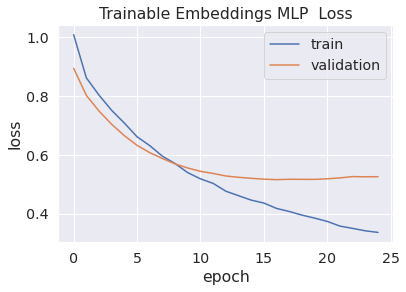

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Trainable Embeddings MLP  Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Results

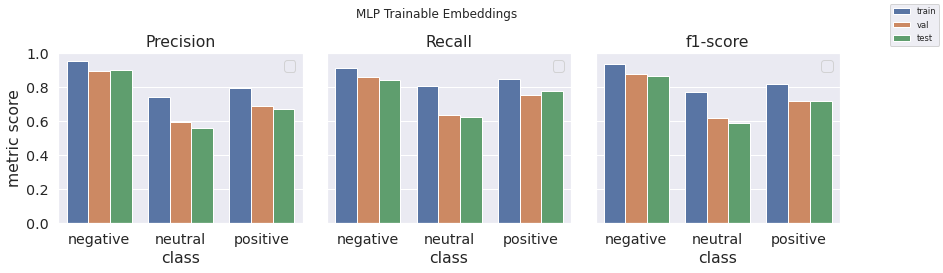

In [ ]:
res_mlp_trainable_embed = pd.DataFrame(
    evaluation(np.argmax(mlp_trainable.predict(train_padded_docs_mlp),axis=1), train.airline_sentiment_label, 'train') \
    + evaluation(np.argmax(mlp_trainable.predict(val_padded_docs_mlp),axis=1), validation.airline_sentiment_label, 'val') \
    + evaluation(np.argmax(mlp_trainable.predict(test_padded_docs_mlp),axis=1), test.airline_sentiment_label, 'test') \
   ,columns = ['negative', 'neutral', 'positive', 'set', 'metric']
)

res_mlp_trainable_embed = pd.melt(res_mlp_trainable_embed, id_vars = ['set','metric'], value_vars=['negative','neutral','positive'], var_name='class', value_name='score')
clf_plot_evaluation(res_mlp_trainable_embed, 'MLP Trainable Embeddings')

In [ ]:
predictions = mlp_trainable.predict(test_padded_docs_mlp)
predictions = predictions.argmax(axis=1)
from sklearn.metrics import classification_report
cr_embed = classification_report(predictions, test.airline_sentiment_label, output_dict=True, target_names=['negative', 'neutral', 'positive'])
pd.DataFrame(cr_embed)

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.899709,0.559140,0.670423,0.790528,0.709757,0.803193
recall,0.839891,0.623501,0.780328,0.790528,0.747907,0.790528
f1-score,0.868772,0.589569,0.721212,0.790528,0.726518,0.795259
support,1474.000000,417.000000,305.000000,0.790528,2196.000000,2196.000000


# Bidirectional GRU


For this approach we will use Stacked Bidirectinal GRUs with an custom Attention layer. Since we implement RNNs and not BOW, we need to account for the unknown tokens inside the sentence.

In [ ]:
t = Tokenizer(oov_token='__UNK__')
t.fit_on_texts(train.cleaned_text)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(train.cleaned_text)
max_len = 32
train_padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
y_train = np.vstack(train.airline_sentiment_label_one_hot)

In [ ]:
val_encoded_docs = t.texts_to_sequences(validation.cleaned_text)
val_padded_docs = pad_sequences(val_encoded_docs, maxlen=max_len, padding='post')
y_val = np.vstack(validation.airline_sentiment_label_one_hot)

test_encoded_docs = t.texts_to_sequences(test.cleaned_text)
test_padded_docs = pad_sequences(test_encoded_docs, maxlen=max_len, padding='post')
y_test = np.vstack(test.airline_sentiment_label_one_hot)

We create the embedding matrix as a left join between the Vocabulary and the pretrained Glove Embeddings.

In [ ]:
vocabulary = pd.DataFrame.from_dict(data=t.word_index, orient='index')
embedding_matrix = pd.merge(vocabulary, pretrained_embeddings, how='left', right_index=True, left_index=True)
embedding_matrix = embedding_matrix.iloc[:,1:]
embedding_matrix = embedding_matrix.loc[vocabulary.index]
embedding_matrix = embedding_matrix.fillna(embedding_matrix.mean())
embedding_matrix = np.vstack((np.zeros((1, embedding_matrix.shape[1])),
                       embedding_matrix))

For deciding the max length of each input sequence we can check

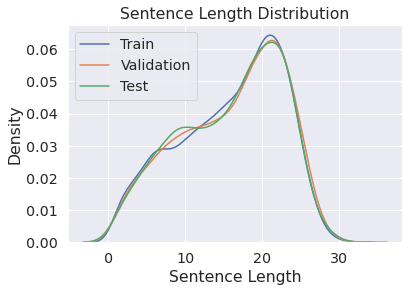

In [ ]:
sns.kdeplot(train.cleaned_text.apply(lambda x: len(x.split())), label = 'Train')
sns.kdeplot(validation.cleaned_text.apply(lambda x: len(x.split())), label = 'Validation')
sns.kdeplot(test.cleaned_text.apply(lambda x: len(x.split())), label = 'Test')
plt.xlabel('Sentence Length')
plt.title('Sentence Length Distribution')
plt.legend()
plt.show()

## The Attention Layer class

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
import numpy as np

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
      return K.dot(x, kernel)

class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 hidden_units=16,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        self.hidden_units = hidden_units
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(self.hidden_units, input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b1 = self.add_weight(shape=(self.hidden_units,),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
        else:
            self.b1 = None
            self.b2 = None

        self.u = self.add_weight(shape=(self.hidden_units,),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

## Bidirectional GRU with Attention Layer Hypermodel

In [ ]:
import shutil
shutil.rmtree('GRU_BIDIR_DEEP_ATTENTION')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner import Objective

class GruDeepAttention(HyperModel):

    def __init__(self, num_classes, vocab_size, max_len, embedding_matrix):
        super().__init__()
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embedding_matrix = embedding_matrix
        

    def build(self, hp):
    
        hp_attention = hp.Int('attention_hidden_units', min_value=32, max_value=64, step=16)    
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])


        model = Sequential()
        model.add( Embedding(input_dim=self.vocab_size, output_dim=self.embedding_matrix.shape[1], weights=[self.embedding_matrix], 
                         input_length=self.max_len, mask_zero=True, trainable=True))

        # Define dynic bidirectional layers
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Bidirectional(
                GRU(
                    units=hp.Int('units_' + str(i),
                        min_value=128,
                        max_value=256,
                        step=64)
                    ,return_sequences=True
                    ,recurrent_dropout = hp.Float('recurrent_dropout_' + str(i),
                        min_value=0.2,
                        max_value=0.5,
                        step=0.1)
                    )
                )
            )
       
        model.add(DeepAttention(return_attention=False, hidden_units=hp_attention))

        model.add(Dense(self.num_classes, activation='softmax'))
        print(model.summary())

        model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(lr=hp_learning_rate),
                 metrics=["accuracy"])

        return model


gru_deep_attention = GruDeepAttention(3, vocab_size, max_len, embedding_matrix)

tuner = BayesianOptimization(
    gru_deep_attention,
    objective='val_loss',
    max_trials=30,
    directory='GRU_BIDIR_DEEP_ATTENTION',
    project_name='RNN',
    seed = 1234,
    )

with tf.device('/device:GPU:0'):
    tuner.search(train_padded_docs, y_train,
                epochs=30,
                validation_data=(val_padded_docs, y_val),
                batch_size=256,
                callbacks=[
                    Metrics(valid_data=(val_padded_docs, y_val))
                    ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
                    ]
                )

Trial 30 Complete [00h 02m 26s]
val_loss: 0.4918695390224457

Best val_loss So Far: 0.4734945595264435
Total elapsed time: 01h 37m 43s
INFO:tensorflow:Oracle triggered exit


## Fitting

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)
print(best_model.summary())

history = best_model.fit(
    train_padded_docs, y_train,
    epochs=30,
    validation_data=(val_padded_docs, y_val),
    batch_size=256,
    callbacks=[
        Metrics(valid_data=(val_padded_docs, y_val))
        ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 300)           3277800   
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 256)           330240    
_________________________________________________________________
deep_attention (DeepAttentio (None, 256)               12385     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 3,621,196
Trainable params: 3,621,196
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 300)           3277800   
_____________________

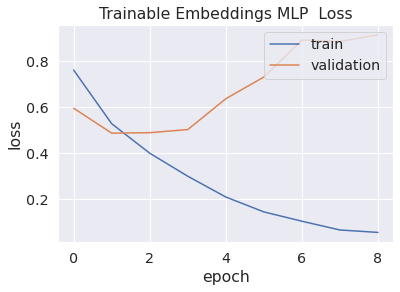

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Trainable Embeddings MLP  Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Save the model and zip it.

In [ ]:
best_model.save('bidirerctional_deep_attention')

INFO:tensorflow:Assets written to: bidirerctional_deep_attention/assets


In [ ]:
!zip -r bidirerctional_deep_attention.zip bidirerctional_deep_attention

  adding: bidirerctional_deep_attention/ (stored 0%)
  adding: bidirerctional_deep_attention/variables/ (stored 0%)
  adding: bidirerctional_deep_attention/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: bidirerctional_deep_attention/variables/variables.index (deflated 69%)
  adding: bidirerctional_deep_attention/assets/ (stored 0%)
  adding: bidirerctional_deep_attention/saved_model.pb (deflated 90%)


Unzip the model and load it into colab.

In [ ]:
!unzip bidirerctional_deep_attention.zip

Archive:  bidirerctional_deep_attention.zip
replace bidirerctional_deep_attention/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: bidirerctional_deep_attention/variables/variables.data-00000-of-00001  
  inflating: bidirerctional_deep_attention/variables/variables.index  
  inflating: bidirerctional_deep_attention/saved_model.pb  


In [ ]:
from keras import models
bidirerctional_deep_attention = models.load_model('bidirerctional_deep_attention')

## Results

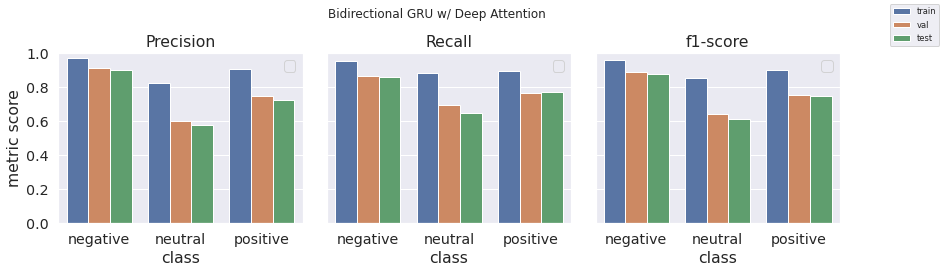

In [ ]:
res_bidirerctional_deep_attention = pd.DataFrame(
    evaluation(np.argmax(bidirerctional_deep_attention.predict(train_padded_docs),axis=1), train.airline_sentiment_label, 'train') \
    + evaluation(np.argmax(bidirerctional_deep_attention.predict(val_padded_docs),axis=1), validation.airline_sentiment_label, 'val') \
    + evaluation(np.argmax(bidirerctional_deep_attention.predict(test_padded_docs),axis=1), test.airline_sentiment_label, 'test') \
   ,columns = ['negative', 'neutral', 'positive', 'set', 'metric']
)

res_bidirerctional_deep_attention = pd.melt(res_bidirerctional_deep_attention, id_vars = ['set','metric'], value_vars=['negative','neutral','positive'], var_name='class', value_name='score')
clf_plot_evaluation(res_bidirerctional_deep_attention, 'Bidirectional GRU w/ Deep Attention')

In [ ]:
predictions = bidirerctional_deep_attention.predict(test_padded_docs)
predictions = predictions.argmax(axis=1)
from sklearn.metrics import classification_report
cr_embed = classification_report(predictions, test.airline_sentiment_label, output_dict=True, target_names=['negative', 'neutral', 'positive'])
pd.DataFrame(cr_embed)

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.903343,0.576344,0.726761,0.805556,0.735483,0.815136
recall,0.857241,0.650485,0.772455,0.805556,0.760061,0.805556
f1-score,0.879689,0.611174,0.748911,0.805556,0.746592,0.809421
support,1450.000000,412.000000,334.000000,0.805556,2196.000000,2196.000000


# Bidirectional GRU with ELMo embeddings

In [ ]:
!pip install tensorflow==1.13.1
!pip install Keras==2.2.4
!pip install tensorflow-hub==0.7.0

     |████████████████████████████████| 92.6MB 48kB/s 
     |████████████████████████████████| 368kB 56.2MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 3.2MB 53.0MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


     |████████████████████████████████| 317kB 17.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


     |████████████████████████████████| 92kB 8.6MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
from keras.layers import Layer

class ELMo(Layer):
    def __init__(self, elmo_representation='elmo', trainable=False, **kwargs):
        self.module_output = elmo_representation
        self.trainable = trainable

        self.elmo = None
        super(ELMo, self).__init__(**kwargs)

    def build(self, input_shape):
        # SetUp tensorflow Hub module
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2',
                               trainable=self.trainable, name="{}_module".format(self.name))
        
        # Assign module's trainable weights to model
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        
        super(ELMo, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                           as_dict=True,
                           signature='default',
                           )[self.module_output]
        return result

    def compute_mask(self, inputs, mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[0], 1024

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Bidirectional,  GRU
from keras.layers import Dense, TimeDistributed, concatenate

GRU_SIZE = 300
DENSE = 64

# And the strig as it is...
elmo_inputs = Input(shape=(1,), dtype='string')

# ELMo embeddings as weighted sum across layers --> ['elmo'] module output
elmo_embeddings = ELMo()(elmo_inputs)

# Define an RNN (Biderectional) with LSTM cells
bilstm = Bidirectional(GRU(units=GRU_SIZE, return_sequences=False, recurrent_dropout = 0.33))(elmo_embeddings)

# Apply Dropout to the bilstm representation
drop_encodings = Dropout(0.33)(bilstm)

# Pass through a Dense Layer
hidden = Dense(units=DENSE, activation="relu")(drop_encodings)

# Apply Dropout to the output of the Dense Layer
drop_out = Dropout(0.33)(hidden)

# Last pass through a Dense Layer with softmax activation to produce a probability distribution
out = Dense(units=3, activation="softmax")(drop_out)

# Wrap model --> Remember Functional API
model = Model(inputs=elmo_inputs, outputs=out)

model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=["accuracy"])
# Print topology
print(model.summary(110))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_6 (InputLayer)                             (None, 1)                                   0                
______________________________________________________________________________________________________________
el_mo_6 (ELMo)                                   (None, None, 1024)                          4                
______________________________________________________________________________________________________________
bidirectional_4 (Bidirectional)                  (None, 600)                                 2385000          
______________________________________________________________________________________________________________
dropout_7 (Dropout)                              (None, 600)                                 0                
_

## Fitting

In [ ]:
history = model.fit(
    train['cleaned_text'], y_train,
    epochs=30,
    validation_data=(validation['cleaned_text'], y_val),
    batch_size=256,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    ]
)

Train on 9955 samples, validate on 2489 samples
Epoch 1/30
9955/9955 [==============================] - 2056s 206ms/step - loss: 0.4978 - acc: 0.8045 - val_loss: 0.4750 - val_acc: 0.8092
Epoch 2/30
9955/9955 [==============================] - 2071s 208ms/step - loss: 0.4411 - acc: 0.8226 - val_loss: 0.5152 - val_acc: 0.8140
Epoch 3/30
9955/9955 [==============================] - 2092s 210ms/step - loss: 0.3837 - acc: 0.8465 - val_loss: 0.4549 - val_acc: 0.8184
Epoch 4/30
9955/9955 [==============================] - 2075s 208ms/step - loss: 0.3370 - acc: 0.8721 - val_loss: 0.4640 - val_acc: 0.8264
Epoch 5/30
9955/9955 [==============================] - 2053s 206ms/step - loss: 0.2639 - acc: 0.8985 - val_loss: 0.5257 - val_acc: 0.8067
Epoch 6/30
9955/9955 [==============================] - 2054s 206ms/step - loss: 0.2075 - acc: 0.9195 - val_loss: 0.5798 - val_acc: 0.8184
Epoch 7/30
9955/9955 [==============================] - 2095s 210ms/step - loss: 0.1655 - acc: 0.9384 - val_loss: 0.60

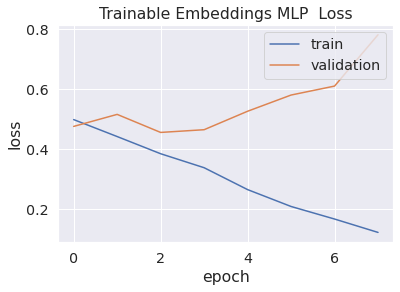

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Trainable Embeddings MLP  Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Save the model and zip it.

In [ ]:
model.save_weights('elmo_bigru_weights.h5')

In [ ]:
!zip -r elmo_bigru.zip elmo_bigru.h5

  adding: elmo_bigru.h5 (deflated 7%)


Unzip the model and load it into colab.

In [ ]:
!unzip elmo_bigru.zip

Archive:  elmo_bigru.zip
replace elmo_bigru.hd5? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: elmo_bigru.hd5          


In [ ]:
elmo_predictions_train = pd.read_csv('elmo_predictions_train.csv', header=None, dtype=int)
elmo_predictions_validation = pd.read_csv('elmo_predictions_validation.csv', header=None, dtype=int)
elmo_predictions_test = pd.read_csv('elmo_predictions_test.csv', header=None, dtype=int)

## Results

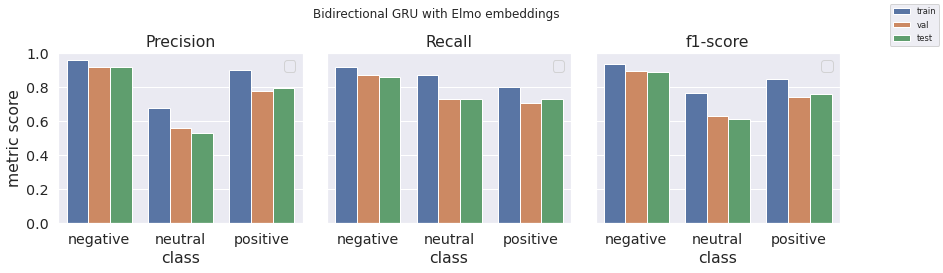

In [ ]:
res_elmo = pd.DataFrame(
    evaluation(elmo_predictions_train, train.airline_sentiment_label, 'train') \
    + evaluation(elmo_predictions_validation, validation.airline_sentiment_label, 'val') \
    + evaluation(elmo_predictions_test, test.airline_sentiment_label, 'test') \
   ,columns = ['negative', 'neutral', 'positive', 'set', 'metric']
)

res_elmo = pd.melt(res_elmo, id_vars = ['set','metric'], value_vars=['negative','neutral','positive'], var_name='class', value_name='score')
clf_plot_evaluation(res_elmo, 'Bidirectional GRU with Elmo embeddings')

In [ ]:
cr_elmo = classification_report(elmo_predictions_test, test.airline_sentiment_label, output_dict=True, target_names=['negative', 'neutral', 'positive'])
pd.DataFrame(cr_elmo)

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.920058,0.531183,0.797183,0.817851,0.749475,0.838550
recall,0.860639,0.730769,0.731266,0.817851,0.774225,0.817851
f1-score,0.889357,0.615193,0.762803,0.817851,0.755784,0.824856
support,1471.000000,338.000000,387.000000,0.817851,2196.000000,2196.000000


# Classifiers Comparison

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, train.airline_sentiment_label)            

def calc_metrics(clf_name, y, predictions , set_type):
    metrics = [precision_score, recall_score, f1_score]
    metric_names = ['precision', 'recall', 'f1_score']
    res = []
    for metric, metric_name in zip(metrics, metric_names):
        score = metric(predictions, y, average='macro')
        res.append((clf_name, set_type, metric_name, score))
    return res



dummy_metrics_train = calc_metrics('dummy', dummy.predict(X_train), train.airline_sentiment_label, 'train')
dummy_metrics_val = calc_metrics('dummy', dummy.predict(X_val), validation.airline_sentiment_label, 'validation')
dummy_metrics_test = calc_metrics('dummy', dummy.predict(X_test), test.airline_sentiment_label, 'test')

lr_metrics_train = calc_metrics('Log Reg', lr.predict(X_train), train.airline_sentiment_label, 'train')
lr_metrics_val = calc_metrics('Log Reg', lr.predict(X_val), validation.airline_sentiment_label, 'validation')
lr_metrics_test = calc_metrics('Log Reg', lr.predict(X_test), test.airline_sentiment_label, 'test')

te_metrics_train = calc_metrics('Tr/ble Emb MLP', np.argmax(mlp_trainable.predict(train_padded_docs_mlp), 1), train.airline_sentiment_label, 'train')
te_metrics_val = calc_metrics('Tr/ble Emb MLP', np.argmax(mlp_trainable.predict(val_padded_docs_mlp), 1), validation.airline_sentiment_label, 'validation')
te_metrics_test = calc_metrics('Tr/ble Emb MLP', np.argmax(mlp_trainable.predict(test_padded_docs_mlp), 1), test.airline_sentiment_label, 'test')

bigru_da_metrics_train = calc_metrics('BiGRU-DA', np.argmax(bidirerctional_deep_attention.predict(train_padded_docs), 1), train.airline_sentiment_label, 'train')
bigru_da_metrics_val = calc_metrics('BiGRU-DA', np.argmax(bidirerctional_deep_attention.predict(val_padded_docs), 1), validation.airline_sentiment_label, 'validation')
bigru_da_metrics_test = calc_metrics('BiGRU-DA', np.argmax(bidirerctional_deep_attention.predict(test_padded_docs), 1), test.airline_sentiment_label, 'test')

elmo_metrics_train = calc_metrics('ELMO-BiGRU', elmo_predictions_train, train.airline_sentiment_label, 'train')
elmo_metrics_val = calc_metrics('ELMO-BiGRU', elmo_predictions_validation, validation.airline_sentiment_label, 'validation')
elmo_metrics_test = calc_metrics('ELMO-BiGRU', elmo_predictions_test, test.airline_sentiment_label, 'test')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


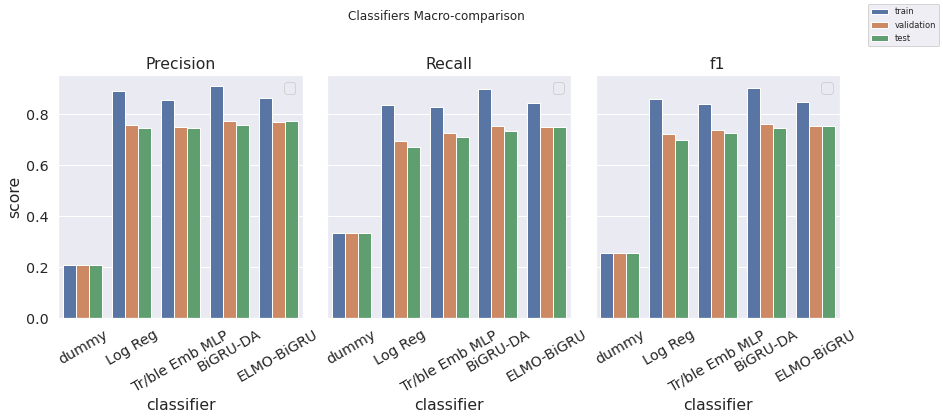

In [ ]:
classifiers_comparison = pd.DataFrame(
    dummy_metrics_train
    +dummy_metrics_val
    +dummy_metrics_test
    +lr_metrics_train
    +lr_metrics_val
    +lr_metrics_test
    +te_metrics_train
    +te_metrics_val
    +te_metrics_test
    +bigru_da_metrics_train
    +bigru_da_metrics_val
    +bigru_da_metrics_test
    +elmo_metrics_train
    +elmo_metrics_val
    +elmo_metrics_test
    ,columns = ['classifier', 'set', 'metric', 'score']
)


fig, axs = plt.subplots(1, 3, figsize=(14,5), sharey=True)
fig.subplots_adjust(top=0.8, wspace=0.1)

sns.barplot(x='classifier', y='score', hue='set', data=classifiers_comparison[classifiers_comparison.metric=='precision'], ax=axs[0])
axs[0].title.set_text('Precision')
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=30)

sns.barplot(x='classifier', y='score', hue='set', data=classifiers_comparison[classifiers_comparison.metric=='recall'], ax=axs[1])
axs[1].title.set_text('Recall')
axs[1].set_ylabel('')
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=30)

sns.barplot(x='classifier', y='score', hue='set', data=classifiers_comparison[classifiers_comparison.metric=='f1_score'], ax=axs[2])
axs[2].title.set_text('f1')
axs[2].set_ylabel('')
axs[2].set_xticklabels(axs[2].get_xticklabels(),rotation=30)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[:0], labels[:0]) 
axs[1].legend(handles[:0], labels[:0])
axs[2].legend(handles[:0], labels[:0]) 
fig.legend(handles, labels, loc='upper right', fontsize='small')

plt.suptitle('Classifiers Macro-comparison')
plt.show()

In [ ]:
classifiers_comparison[(classifiers_comparison['set']=='test') & (classifiers_comparison['metric']=='f1_score')]

,classifier,set,metric,score
8,dummy,test,f1_score,0.256812
17,Log Reg,test,f1_score,0.699814
26,Tr/ble Emb MLP,test,f1_score,0.726518
35,BiGRU-DA,test,f1_score,0.746592
44,ELMO-BiGRU,test,f1_score,0.755784


# Spacy - Optional

In [ ]:
!pip install -U spacy

In [ ]:
!pip install -U pip setuptools wheel

In [ ]:
!python -m spacy download en_core_web_lg

2021-03-25 18:05:15.710387: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 778.8 MB 19 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
from spacy.tokens import DocBin
from spacy.training import Example
import spacy

def spacy_format(df, filename):
    DATA = []
    db = DocBin()
    for _, row in df.iterrows():
        doc = nlp(row.cleaned_text)
        labels = {'cats':  {'NEGATIVE':row.airline_sentiment_label_one_hot[0]
                            ,'NEUTRAL':row.airline_sentiment_label_one_hot[1]
                            ,'POSITIVE':row.airline_sentiment_label_one_hot[2]}
        }
        example = Example.from_dict(doc, labels)
        db.add(example.reference)
    db.to_disk(filename + ".spacy")

In [ ]:
nlp = spacy.load('en_core_web_lg')
spacy_format(train,'train_data')
spacy_format(validation,'validation_data')
spacy_format(test,'test_data')

In [ ]:
!python -m spacy init fill-config textcat_config.cfg textcat_config.cfg

2021-03-25 17:51:12.997550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Auto-filled config with all values
✔ Saved config
textcat_config.cfg
You can now add your data and train your pipeline:
python -m spacy train textcat_config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
!python -m spacy train textcat_config.cfg --output text_catv1 --paths.train train_data.spacy --paths.dev validation_data.spacy --gpu-id 0

2021-03-25 22:10:27.744442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2021-03-25 22:10:31,923] [INFO] Set up nlp object from config
[2021-03-25 22:10:31,933] [INFO] Pipeline: ['tok2vec', 'textcat']
[2021-03-25 22:10:31,938] [INFO] Created vocabulary
[2021-03-25 22:10:35,554] [INFO] Added vectors: en_core_web_lg
[2021-03-25 22:10:35,554] [INFO] Finished initializing nlp object
[2021-03-25 22:10:49,095] [INFO] Initialized pipeline components: ['tok2vec', 'textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS TEXTCAT  CATS_MACRO_F  SCORE 
---  ------  ------------  ------------  ------------  ------
  0       0          0.00          0.04          0.00    0.00
  0     20

In [ ]:
spacy_clf = spacy.load('text_catv1/model-best')

In [ ]:
spacy_predictions = test.cleaned_text.apply(lambda x: np.array(list(spacy_clf(x).cats.values())))
spacy_predictions = spacy_predictions.apply(lambda x: np.argmax(x))

In [ ]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(test.airline_sentiment_label, spacy_predictions, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.850932,0.627078,0.773006,0.796448,0.750339,0.790934
recall,0.896076,0.567742,0.709859,0.796448,0.724559,0.796448
f1-score,0.872920,0.595937,0.740088,0.796448,0.736315,0.792796
support,1376.000000,465.000000,355.000000,0.796448,2196.000000,2196.000000
